In [ ]:
%pip install -q huggingface_hub datasets
%pip install -q matplotlib torch torchxrayvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 32.5 MB/s eta 0:00:00


In [ ]:
!kaggle datasets download -d emirhanyldz/chest-xray
!unzip chest-xray.zip -d chest-xray

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: chest-xray/images/00003122_017.png  
  inflating: chest-xray/images/00003124_000.png  
  inflating: chest-xray/images/00003129_000.png  
  inflating: chest-xray/images/00003129_001.png  
  inflating: chest-xray/images/00003129_004.png  
  inflating: chest-xray/images/00003129_009.png  
  inflating: chest-xray/images/00003129_011.png  
  inflating: chest-xray/images/00003135_000.png  
  inflating: chest-xray/images/00003140_007.png  
  inflating: chest-xray/images/00003159_001.png  
  inflating: chest-xray/images/00003169_001.png  
  inflating: chest-xray/images/00003177_002.png  
  inflating: chest-xray/images/00003186_004.png  
  inflating: chest-xray/images/00003186_005.png  
  inflating: chest-xray/images/00003190_018.png  
  inflating: chest-xray/images/00003191_001.png  
  inflating: chest-xray/images/00003198_002.png  
  inflating: chest-xray/images/00003198_005.png  
  inflating: chest-xray/images/00003198_009.png  
  i

In [ ]:
import torchxrayvision as xrv
import torch

model = xrv.models.ResNet(weights="resnet50-res512-all")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
model.eval()

XRV-ResNet-resnet50-res512-all

In [ ]:
import numpy as np
from PIL import Image
import skimage
import torchvision

img= skimage.io.imread("/content/chest-xray/images/00000030_001.png") 
img = xrv.datasets.normalize(img, 255, reshape=True) 
transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),xrv.datasets.XRayResizer(512)])

img = transform(img)
image = torch.from_numpy(img)


In [ ]:
def load_image(img_path):
    image = xrv.utils.load_image(img_path)
    transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),xrv.datasets.XRayResizer(512)])
    image = transform(image)
    image = torch.from_numpy(image)
    return image

In [ ]:
image = load_image("/content/chest-xray/images/00010790_007.png")

In [ ]:
output = model(image[None, ...].to(device))

dict(zip(model.pathologies,output[0].detach().cpu().numpy()))

{'Atelectasis': 0.082925856,
 'Consolidation': 0.12729646,
 'Infiltration': 0.29385975,
 'Pneumothorax': 0.015750034,
 'Edema': 0.103424326,
 'Emphysema': 0.009073471,
 'Fibrosis': 0.010934077,
 'Effusion': 0.096479304,
 'Pneumonia': 0.09776858,
 'Pleural_Thickening': 0.041714903,
 'Cardiomegaly': 0.009403771,
 'Nodule': 0.056823988,
 'Mass': 0.04097574,
 'Hernia': 0.00036557185,
 'Lung Lesion': 0.5,
 'Fracture': 0.074051484,
 'Lung Opacity': 0.6961935,
 'Enlarged Cardiomediastinum': 0.5}

In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchxrayvision as xrv
from sklearn.metrics import accuracy_score, roc_auc_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CustomNIHDataset(Dataset):
    def __init__(self, img_dir, csv_file, transform=None):
        self.img_dir = img_dir
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.pathologies = [
            "Atelectasis", "Cardiomegaly", "Effusion", "Infiltration",
            "Mass", "Nodule", "Pneumonia", "Pneumothorax", "Consolidation",
            "Edema", "Emphysema", "Fibrosis", "Pleural_Thickening", "Hernia"
        ]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx]["Image Index"])
        image = skimage.io.imread(img_name)
        label = np.zeros(len(self.pathologies), dtype=np.float32)
        image = xrv.datasets.normalize(image, 255, reshape=True)

        for i, pathology in enumerate(self.pathologies):
            if pathology in self.data.iloc[idx]["Finding Labels"]:
                label[i] = 1.0

        if self.transform:
            image = self.transform(image)

        image = torch.from_numpy(image)

        return image, torch.tensor(label, dtype=torch.float32)


In [ ]:
transform = transforms.Compose([
    xrv.datasets.XRayCenterCrop(),
    xrv.datasets.XRayResizer(512)
])

img_dir = "/content/chest-xray/images"  
csv_file = "/content/chest-xray/labels.csv"  
val_dataset = CustomNIHDataset(img_dir=img_dir, csv_file=csv_file, transform=transform)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model = xrv.models.ResNet(weights="resnet50-res512-all")
model = model.to(device)
model.eval()  

If this fails you can run `wget https://github.com/mlmed/torchxrayvision/releases/download/v1/pc-nih-rsna-siim-vin-resnet50-test512-e400-state.pt -O /root/.torchxrayvision/models_data/pc-nih-rsna-siim-vin-resnet50-test512-e400-state.pt`
[██████████████████████████████████████████████████]


XRV-ResNet-resnet50-res512-all

In [ ]:
all_labels = []
all_outputs = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        all_labels.extend(labels.cpu().numpy())
        all_outputs.extend(outputs[:, :14].cpu().numpy())

all_labels = np.array(all_labels)
all_outputs = np.array(all_outputs)

for i, pathology in enumerate(val_dataset.pathologies):
    auc = roc_auc_score(all_labels[:, i], all_outputs[:, i])
    print(f"{pathology} için ROC-AUC: {auc:.4f}")


Atelectasis için ROC-AUC: 0.8053
Cardiomegaly için ROC-AUC: 0.5836
Effusion için ROC-AUC: 0.6662
Infiltration için ROC-AUC: 0.5633
Mass için ROC-AUC: 0.5533
Nodule için ROC-AUC: 0.5150
Pneumonia için ROC-AUC: 0.5022
Pneumothorax için ROC-AUC: 0.6728
Consolidation için ROC-AUC: 0.7471
Edema için ROC-AUC: 0.5290
Emphysema için ROC-AUC: 0.4457
Fibrosis için ROC-AUC: 0.7296
Pleural_Thickening için ROC-AUC: 0.6743
Hernia için ROC-AUC: 0.8995


In [ ]:
model.pathologies

['Atelectasis',
 'Consolidation',
 'Infiltration',
 'Pneumothorax',
 'Edema',
 'Emphysema',
 'Fibrosis',
 'Effusion',
 'Pneumonia',
 'Pleural_Thickening',
 'Cardiomegaly',
 'Nodule',
 'Mass',
 'Hernia',
 '',
 '',
 '',
 '']

In [ ]:
img = skimage.io.imread('/content/chest-xray/images/00010790_007.png')
img = xrv.datasets.normalize(img, 255)

if len(img.shape) > 2:
    img = img[:, :, 0]
if len(img.shape) < 2:
    print("error, dimension lower than 2 for image")

img = img[None, :, :]

transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),
                                            xrv.datasets.XRayResizer(224)])

img = transform(img)
img = torch.from_numpy(img).unsqueeze(0)

In [ ]:
img.shape

torch.Size([1, 1, 224, 224])

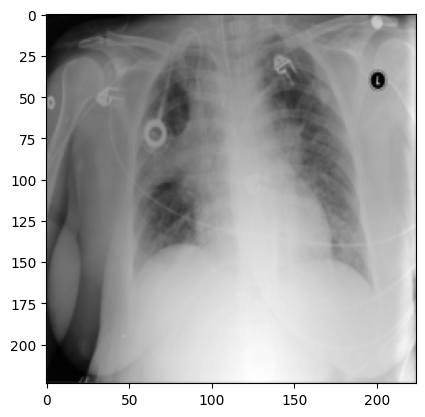

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(img[0][0], cmap='gray')

In [ ]:
target = model.pathologies.index('Atelectasis')

tensor([0.5771], device='cuda:0', grad_fn=<SelectBackward0>)


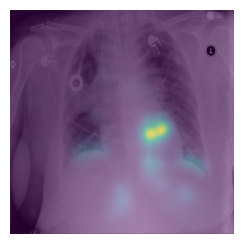

In [ ]:
img = img.requires_grad_()

outputs = model(img.to(device))
print(outputs[:,target])
grads = torch.autograd.grad(outputs[:,target], img)[0][0][0]
blurred = skimage.filters.gaussian(grads.detach().cpu().numpy()**2, sigma=(5, 5), truncate=3.5)

my_dpi = 100
fig = plt.figure(frameon=False, figsize=(224/my_dpi, 224/my_dpi), dpi=my_dpi)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(img[0][0].detach().cpu().numpy(), cmap="gray", aspect='auto')
ax.imshow(blurred, alpha=0.5);